In [3]:
import numpy as np
import matplotlib.pyplot as plt
import meshplot as mp
import itertools
from tqdm import tqdm

from utils import  sample_torus, get_ot_params, sample_torus_unbalanced
import gudhi as gd
from mapper import MapperComplex
from sklearn.cluster import KMeans
from ot import gromov_wasserstein
from sklearn.manifold import MDS
import matplotlib as mpl
import matplotlib.cm as cm
import networkx as nx


In [4]:
R=0.75
r=0.25

In [5]:
points=sample_torus(200000,R,r)

In [6]:
points.shape

(200000, 3)

In [7]:
mp.plot(points);

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-1.341104…

In [8]:
class custom_clustering:
    def __init__(self,R,r):
        self.R = R
        self.r = r

    def fit_predict(self,X):
        if np.sum(X[:,1]>(R-r)) + np.sum(X[:,1]<(-R+r)) >0:
            return np.repeat(0,X.shape[0])
        return (X[:,0]>0).astype(int)

In [9]:
clus=custom_clustering(R,r)

In [10]:
size=200000
resolutions=np.array([30])
gain=np.array([0.3])

f=points[:,1].reshape((-1,1))
c=np.repeat(1,points.shape[0]).reshape((-1,1))

In [11]:
mapper=MapperComplex(colors=c,filters=f,resolutions=resolutions, gains=gain, clustering=clus)
mapper.fit(points);

In [12]:
nt=mapper.get_pyvis()
nt.show('torus.html')

torus.html


In [13]:
p,C=get_ot_params(mapper,c/points.shape[0],points,R+r)

In [17]:
alpha=1/12
beta=1/12
points=sample_torus_unbalanced(200000,R,r,alpha,beta)
mp.plot(points);

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(7.7486038…

In [18]:
np.random.seed(0)
size=int(5e5)
values=[1/12,1/6,1/3]
c=np.repeat(1,size).reshape((-1,1))
resolutions=np.array([30])
gain=np.array([0.3])
ps=[]
Cs=[]
for alpha,beta in tqdm(itertools.product(values,values)):
    points=sample_torus_unbalanced(size,R,r,alpha,beta)
    f=points[:,1].reshape((-1,1))
    mapper=MapperComplex(colors=c,filters=f,resolutions=resolutions, gains=gain, clustering=clus)
    mapper.fit(points);
    p_u,C_u=get_ot_params(mapper,c/size,points,R+r)
    ps.append(p_u)
    Cs.append(C_u)

9it [00:49,  5.53s/it]


In [19]:
M=np.zeros((9,9))
for i in range(9):
    for j in range(i):
        T,l=gromov_wasserstein(Cs[i], Cs[j], p=ps[i], q=ps[j],symmetric=True,log=True)
        M[i,j]=l['gw_dist']
        M[j,i]=M[i,j]

In [20]:
embedding = MDS(n_components=2,dissimilarity='precomputed')
X = embedding.fit_transform(M)

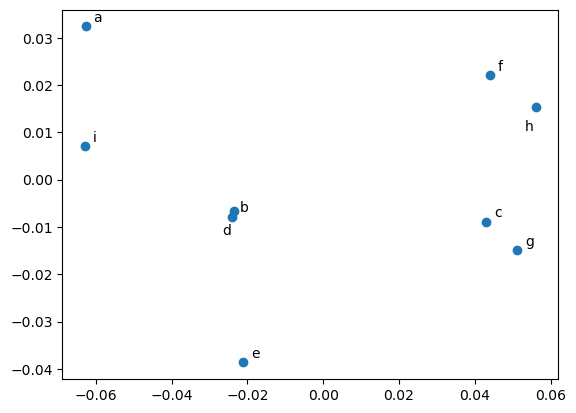

In [21]:

labels = ['a','b','c','d','e','f','g','h','i']

fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1])
for i, txt in enumerate(labels):
    if i==7 or i==3:
        ax.annotate(txt, (X[i,0], X[i,1]),(X[i,0]-0.003, X[i,1]-0.005))
    else:    
        ax.annotate(txt, (X[i,0], X[i,1]),(X[i,0]+0.002, X[i,1]+0.001))

fig.savefig("mds.png")

In [23]:
M.sum(axis=0)

array([0.69419561, 0.44729754, 0.49733636, 0.44467399, 0.54355171,
       0.51497607, 0.55239735, 0.57624176, 0.64675462])

## Graph visualization

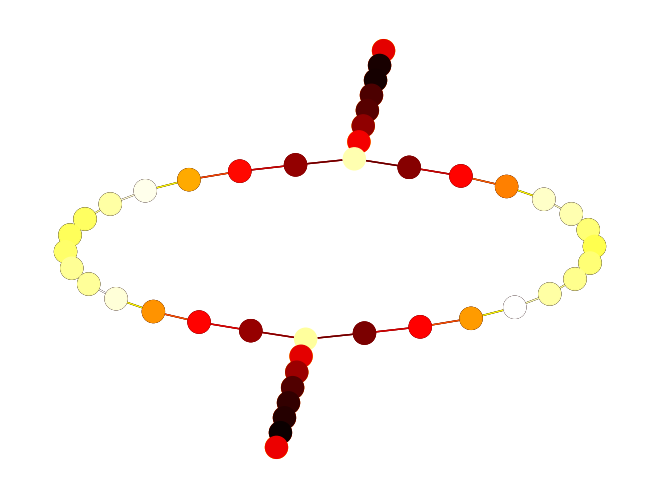

In [25]:
values=[1/12,1/6,1/3]
for alpha,beta in zip(values,values):
    points=sample_torus_unbalanced(size,R,r,alpha,beta)
    f=points[:,1].reshape((-1,1))
    mapper=MapperComplex(colors=c,filters=f,resolutions=resolutions, gains=gain, clustering=clus)
    mapper.fit(points);
    ni=mapper.node_info.copy()
    edge_colors=[]
    st=mapper.simplex_tree

    for (splx,_) in st.get_skeleton(1):
        if len(splx) == 2:
            inter=np.intersect1d(ni[splx[0]]['indices'], ni[splx[1]]['indices'],assume_unique=True)
            edge_colors.append(inter.size)
            ni[splx[0]]['indices']=np.setdiff1d(ni[splx[0]]['indices'], inter, assume_unique=True)
            ni[splx[1]]['indices']=np.setdiff1d(ni[splx[1]]['indices'], inter, assume_unique=True)
    
    node_colors=[node['indices'].size for node in ni.values()]
    
    edge_colors=np.array(edge_colors)/size
    node_colors=np.array(node_colors)/size
    G = nx.Graph()
    
    for splx, _ in st.get_skeleton(1):
        if len(splx) == 1:
            G.add_node(splx[0])
        if len(splx) == 2:
            G.add_edge(splx[0], splx[1])
    
    
    options = {
        "node_color": node_colors,
        "edge_color": edge_colors,
        "node_size":250,
        "edge_cmap": plt.cm.hot,
        "width": 1,
        "with_labels": False,
    }
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G, pos,**options,cmap=plt.cm.hot)
    plt.savefig('mapper'+str(alpha)+'_'+str(beta)+'.png')